In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from utide import solve

In [3]:
from analysis_routines import *
from ploting_routines import *
from processing_routines import datenum_to_epoch
plt.style.use('/home/manu/TFG_repo/notebooks/notebook.mplstyle')

In [131]:
def coef_dataframe(date, value, lat=43.789):
    coef = solve(date, value, lat=lat, nodal=False, verbose=False)
    columns = ['A', 'A_ci', 'g', 'g_ci']
    data_dict = dict((k, coef[k]) for k in ['name', 'PE', 'SNR', 'A', 'A_ci', 'g', 'g_ci'] if k in coef)
    df = pd.DataFrame(data_dict)
    df.insert(1, 'period', 1/coef.aux['frq'])
    df.set_index('name', inplace=True)
    df.attrs['mean'] = coef['mean']
    df.attrs['slope'] = coef['slope']
    return df


class TidalComponentsFit:
    def __init__(self, D1, b2, c2, a2):
        self.D1 = D1
        self.b2 = b2
        self.c2 = c2
        self.a2 = a2
        
    @classmethod
    def compute(cls, df, variables=None, dn=6, lims=[None, None], lat=43.789):
        
        if isinstance(lims[0], datetime):
            lims[0] = date_to_idx(df['date'], lims[0])

        if isinstance(lims[1], datetime):
            lims[1] = date_to_idx(df['date'], lims[1])
        
        slice_ = np.s_[lims[0]:lims[1]:dn]
        date = df['date'][slice_]
        
        if variables is None:
            variables = ['D1', 'b2', 'c2', 'a2']
        
        if 'D1' in variables:
            D1 = df['D1'].to_numpy()[slice_]
            df_D1 = coef_dataframe(date, D1, lat=lat)
        
        else:
            df_D1 = None
        
        if 'b2' in variables:
            b2 = df['b2'].to_numpy()[slice_]
            df_b2 = coef_dataframe(date, b2, lat=lat)
        
        else:
            df_b2 = None
            
        if 'c2' in variables:
            c2 = df['c2'].to_numpy()[slice_]
            df_c2 = coef_dataframe(date, c2, lat=lat)
        
        else:
            df_c2 = None
            
        if 'a2' in variables:
            a2 = df['a2'].to_numpy()[slice_]
            df_a2 = coef_dataframe(date, a2, lat=lat)
        
        else:
            df_a2 = None
            
        return cls(df_D1, df_b2, df_c2, df_a2)
    
    def clean(self):
        
        for var in ['D1', 'b2', 'c2', 'a2']:
            df_var = getattr(self, var)
            if df_var is not None:
                
                df_var = df_var[df_var['SNR'] > 2.0]
                df_var = df_var[df_var['A'] > df_var['A_ci']]
                df_var = df_var[df_var['PE'] > 1]
                setattr(self, var, df_var)

# Harmoic analysis & Utide

In [11]:
temp, pres, date, lat, _ = load_time_series('processed/AGL_20181116_chain.nc', latlon=True)
df_ci = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fci.csv')
df_c = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fc.csv')
df_s = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_s.csv')

### Mareas internas en noviembre, MLD ~ 40 m

In [104]:
# trim time series
dn = 6 # get datapoints every 60 seconds, not every 5
date_1 = datetime(2018, 11, 24)
nov_ci = TidalComponentsFit.compute(df_ci, lims=[0, date_1], dn=dn)
nov_c = TidalComponentsFit.compute(df_c, lims=[0, date_1], dn=dn)
nov_s = TidalComponentsFit.compute(df_s, lims=[0, date_1], dn=dn)

nov_ci.clean()
nov_c.clean()
nov_s.clean()

In [106]:
nov_ci.D1

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,91.461085,132.283826,4.435977,0.755948,4.380153,9.774049
M4,6.210301,4.105564,25.899759,0.939848,0.361964,10.671372,21.985230
M3,8.280401,2.189791,15.197757,0.686392,0.345095,132.232481,28.818188
K1,23.934470,1.194250,8.954144,0.506896,0.332019,329.679221,37.565983


In [66]:
nov_s.D1

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,92.748507,102.928488,4.579239,0.884671,4.430482,11.080515
M4,6.210301,3.389098,28.222816,0.875350,0.322952,13.105206,21.063839
M3,8.280401,1.548530,11.222531,0.591697,0.346187,132.447677,33.534916
K1,23.934470,1.143568,7.645551,0.508476,0.360431,324.202306,40.639652


In [67]:
nov_ci.b2

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,79.888410,14.895970,0.008225,0.004177,194.030263,29.123620
M6,4.140200,5.506948,8.228708,0.002160,0.001476,105.534017,39.232149
M3,8.280401,5.468512,12.649893,0.002152,0.001186,115.218031,31.659848
3MK7,3.529641,3.740899,4.289179,0.001780,0.001684,270.803528,54.135506
2MK5,4.930880,3.279850,4.031037,0.001667,0.001627,315.775614,55.929078


In [68]:
nov_ci.a2

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
K1,23.934470,39.574569,5.715883,0.010395,0.008522,237.584787,46.931635
M3,8.280401,16.354428,33.690921,0.006682,0.002256,229.815618,19.361122
3MK7,3.529641,9.913880,24.404510,0.005203,0.002064,50.344120,22.725426
M4,6.210301,6.754349,11.813675,0.004294,0.002449,83.057677,32.798473
2SK5,4.797373,3.841660,7.668384,0.003239,0.002292,101.000647,40.666618
M8,3.105150,2.307517,12.496022,0.002510,0.001392,61.411431,31.744441
2MK5,4.930880,2.195392,4.373162,0.002448,0.002295,127.526439,53.739331


In [94]:
print('Greenwich phase (degrees) for c+i fit: D1 = {:.0f}, b2 = {:.0f}'.format(nov_ci.D1['g']['M2'], 
                                                                                       nov_ci.b2['g']['M2']))

print('Greenwich phase (degrees) for s fit: D1 = {:.0f}, b2 = {:.0f}'.format(nov_s.D1['g']['M2'], 
                                                                                       nov_s.b2['g']['M2']))


print('Greenwich phase (degrees) for c fit: D1 = {:.0f}, b2 = {:.0f}'.format(nov_c.D1['g']['M2'], 
                                                                                       nov_c.b2['g']['M2']))

Greenwich phase (degrees) for c+i fit: D1 = 4, b2 = 194
Greenwich phase (degrees) for s fit: D1 = 4, b2 = 196
Greenwich phase (degrees) for c fit: D1 = 4, b2 = 196


### Mareas internas principios de diciembre
Mayor amplitud que en noviembre > columna menos estratificada

In [113]:
date_2 = datetime(2018, 11, 30)
date_3 = datetime(2018, 12, 9)
dn = 6 # get datapoints every 60 seconds, not every 5
dec_ci = TidalComponentsFit.compute(df_ci, lims=[date_2, date_3], dn=dn)
dec_c = TidalComponentsFit.compute(df_c, lims=[date_2, date_3], dn=dn)
dec_s = TidalComponentsFit.compute(df_s, lims=[date_2, date_3], dn=dn)

dec_ci.clean()
dec_c.clean()
dec_s.clean()

In [114]:
dec_ci.D1

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,92.529763,266.048418,6.281154,0.754771,8.016580,6.850413
M4,6.210301,1.261943,6.551702,0.733531,0.561691,42.993942,43.863609
2SK5,4.797373,1.044881,40.035511,0.667471,0.206760,248.608380,17.735282
M3,8.280401,1.042122,7.059002,0.666589,0.491748,303.678553,42.300057


In [115]:
dec_ci.b2

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,65.322938,9.255097,0.009090,0.005856,171.214415,36.730277
M4,6.210301,9.238448,33.227459,0.003418,0.001162,260.110929,19.540613
K1,23.934470,7.331014,5.385174,0.003045,0.002572,216.041495,48.459749
M6,4.140200,6.342657,7.117710,0.002832,0.002081,130.705454,42.100079
2MK5,4.930880,4.157998,11.135246,0.002293,0.001347,196.050522,33.634401
M8,3.105150,3.667636,7.208876,0.002154,0.001572,236.125953,41.827284
2SK5,4.797373,2.365274,6.334345,0.001730,0.001347,298.137950,44.595122


In [119]:
date_4 = datetime(2018, 12, 30, 12)
date_5 = datetime(2019, 1, 14)
dn = 6 # get datapoints every 60 seconds, not every 5
wint_ci = TidalComponentsFit.compute(df_ci, lims=[date_4, date_5], dn=dn)
wint_c = TidalComponentsFit.compute(df_c, lims=[date_4, date_5], dn=dn)
wint_s = TidalComponentsFit.compute(df_s, lims=[date_4, date_5], dn=dn)

In [120]:
wint_ci.D1

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,83.995631,208.128296,8.571444,1.164513,61.251905,7.778204
O1,25.819342,7.852250,7.553634,2.620733,1.868963,227.947730,40.864341
M4,6.210301,2.937967,11.853674,1.603058,0.912596,166.176705,32.630325
K1,23.934470,2.870809,2.759136,1.584630,1.869809,123.881375,67.552710
M8,3.105150,0.605071,11.018249,0.727493,0.429565,223.027790,33.831547
M3,8.280401,0.558130,3.855179,0.698704,0.697473,329.146596,57.174494
2SK5,4.797373,0.435064,9.084510,0.616882,0.401151,355.504985,37.279180
3MK7,3.529641,0.338302,4.528155,0.543974,0.501041,286.771069,52.739465
2MK5,4.930880,0.222173,4.631541,0.440831,0.401481,82.394909,52.124167


In [125]:
wint_s.D1

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,81.489565,81.231378,8.899091,1.935262,70.529666,12.446110
O1,25.819342,7.803377,6.352529,2.753822,2.141503,248.292041,44.587681
M4,6.210301,3.520334,11.314763,1.849637,1.077755,128.448731,33.382024
K1,23.934470,2.097035,1.708444,1.427570,2.140687,156.948946,86.043587
M8,3.105150,1.622977,12.755298,1.255888,0.689226,230.670793,31.443797
M3,8.280401,1.252242,6.686489,1.103161,0.836172,330.126648,43.412605
2SK5,4.797373,1.099986,7.727629,1.033923,0.728989,60.810959,40.385830
3MK7,3.529641,0.620916,3.225330,0.776803,0.847774,278.129187,62.483655
2MK5,4.930880,0.366932,2.577687,0.597156,0.729002,53.337289,69.923284


### FFT

In [12]:
temp, pres, date = load_time_series('processed/AGL_20181116_chain.nc')

In [16]:
from scipy.fft import fft, fftfreq, ifft, rfft
from scipy.signal.windows import boxcar
from scipy.signal import welch

def detrend(x):
    n = len(x)
    t = np.arange(n)
    p = np.polyfit(t, x, 1)
    x_detrended = x - np.polyval(p, t)
    return x_detrended

def quadwindow(n):
    t = np.arange(n)
    win = 1- ((t - 0.5 * n) / (0.5 * n)) **2
    return win

def smooth(y, n):
    y_smoothed = np.convolve(y, boxcar(n), mode='valid')
    return y_smoothed

def spectrum(x, dt, n_smooth):
    '''Perform fft of series with spacing dt smoothin the 
    series with a quadratic window and block smoothing the 
    result with blocks of lenght n_smooth
    '''
    n = len(x)
    x = detrend(x)
    win_weights = quadwin(n)
    x *= win_weights
    
    pslice = slice(1, n//2)
    freqs = fftfreq(n, d=dt)[pslice]
    amplitude = rfft(x)[pslice]
    
    power = 2 * np.abs(amplitude)**2 / n**2
    psd = power * dt * n # power spectral density
    psd *= n / (win_weights**2).sum()
    power *= n**2 / win_weights.sum()**2
    
    freqs = smooth(freqs, n_smooth)
    psd = smooth(psd, n_smooth)
    power = smooth(power, n_smooth)
    
    return freqs, power, psd


def windowed_spectrum(x, dt, window_time, n_smooth, window='hann'):
    ''' Perform a windowed fourier transmor over time series x with
    spacing dt. Smooth out the results.
    '''
    N = len(x)
    window_n = window_time/dt
    freqs, psd = welch(x, fs=1/dt, nperseg=window_n, window=window, detrend='linear')
    freqs = smooth(freqs, n_smooth)
    psd = smooth(psd, n_smooth)
    
    return freqs, psd

def plot_spectrum(freqs, pxx, units, lims=None):
    period = 1/freqs
    fig, ax = plt.subplots()
    ax.loglog(period, psd)
    if lims != None:
        ax.set_xlim(*lims)
    ax.set_ylabel(r'Power spectral density (ºC$^2$/{})'.format(units))
    ax.set_xlabel(r'Period ({})'.format(units))
    #ax.axvline(2)
    plt.show()



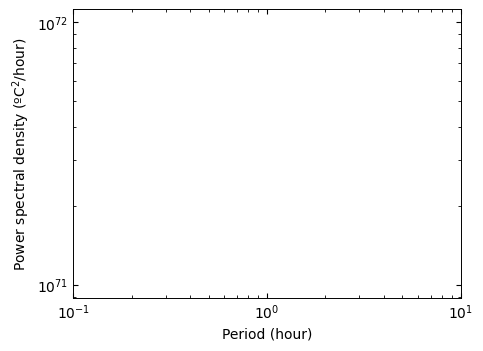

In [17]:
dt = 5/60/60
window_time = 1024
n_smooth = 10
units = 'hour'
freqs, psd = windowed_spectrum(temp[1], dt, window_time, n_smooth)
plot_spectrum(freqs, psd, 'hour', lims=(10**-1, 10))

In [18]:
freqs, power, psd = spectrum(temp[10], dt, n_smooth)
plot_spectrum(freqs, psd, 'hour', lims=(10**-1, 10))

NameError: name 'quadwin' is not defined

In [124]:
xx = np.linspace(0, 10, 300)
a = np.cos(xx) + 1
b = np.cos(xx + np.pi) +1
c = np.cos(xx + np.pi*3/2) +1


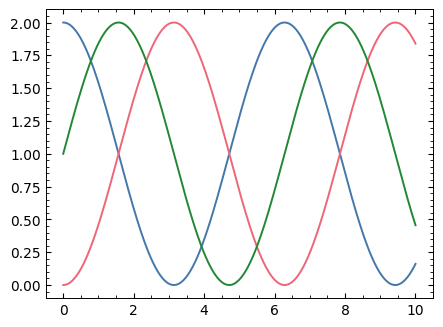

In [125]:
plt.plot(xx, a)
plt.plot(xx, b)
plt.plot(xx, c)